### Imports

In [1]:
import functools
import os
import random
from itertools import combinations
from typing import List, NoReturn

from IPython.display import Image as IPImage, Markdown as IPMarkdown, display, clear_output, HTML
from PIL import Image, ImageDraw

### Types

In [2]:
variable = int
list_of_variable = List[variable]
clause = List[variable]
set_of_clauses = List[clause]

### Constants

In [3]:
UNSAT_GIF = gif = HTML(
        """<div class="tenor-gif-embed" data-postid="21948754" data-share-method="host" data-aspect-ratio="1" data-width="20%"><a href="https://tenor.com/view/sad-cute-cat-gif-21948754">Sad Cute Cat Sticker</a>from <a href="https://tenor.com/search/sad-stickers">Sad Stickers</a></div> <script type="text/javascript" async src="https://tenor.com/embed.js"></script>""")
ERROR_GIF = HTML(
        """<div class="tenor-gif-embed" data-postid="23890778" data-share-method="host" data-aspect-ratio="1.87135" data-width="40%"><a href="https://tenor.com/view/ice-age-sid-ohhhm-this-is-a-problem-we-have-a-problem-problem-gif-23890778">Ice Age Sid GIF</a>from <a href="https://tenor.com/search/ice+age-gifs">Ice Age GIFs</a></div> <script type="text/javascript" async src="https://tenor.com/embed.js"></script>""")

### CNF generator

In [13]:
def get_CNF_n_true_among(values: list_of_variable, n: int) -> set_of_clauses:
    """
    Returns the CNF equivalent to two true variables from the list provided in parameter

    Parameters
    ----------
    values : int
        List of logic variables
    n : int
        Number of true variables

    """
    if n < 1:
        raise ValueError(f"The number of true variables must be at least 1.")
    if len(values) < n:
        raise ValueError(f"The size of the list must be at least {n}.")

    close: set_of_clauses = []

    for j in range(len(values) + 1):
        if j != n:
            for cmb in combinations(values, j):
                close.append([-k if k in cmb else k for k in values])
    return close


def get_CNF_no_true_among_neighbor(var: variable, neighbor: list_of_variable) -> set_of_clauses:
    """
    Returns the CNF equivalent to no true variable among the neighbor of the variable provided in parameter

    Parameters
    ----------
    var : list_of_variable
        Initial variable
    neighbor : list_of_variable
        List of neighbor of the initial variable

    """
    if var in neighbor:
        raise ValueError(f"The variable {var} is in the list of neighbor.")

    return [[-var, -var_neighbor] for var_neighbor in neighbor]

### DIMAC and SAT functions

In [ ]:
def write_DIMAC_clause(path: str, clauses_list: set_of_clauses, nb_of_variable: int) -> NoReturn:
    """
    Write the clause in DIMAC format in the file given in parameter

    Parameters
    ----------
    path : str
        Path of the file where the clause will be written
    clauses_list : set_of_clauses
        Clauses to write in DIMAC format
    nb_of_variable : int
        Number of variable of the grid
    """

    with open(path, 'w') as f:
        f.write(f"p cnf {nb_of_variable} {len(clauses_list)}\n")
        for cls in clauses_list:
            for var in cls:
                f.write(f"{var} ")
            f.write("0\n")

def read_DIMAC(path: str) -> (set_of_clauses, int):
    """
    Read the DIMAC file and return the clauses

    Parameters
    ----------
    path : str
        Path of the file to read

    Returns
    -------
    set_of_clauses
        Clauses of the DIMAC file
    int
        Number of variable of set_of_clauses
    """
    with open(path, 'r') as f:
        lines = f.readlines()

    maxvalue: int = 0
    cnf: set_of_clauses = []

    for line in lines:
        if line.startswith('c'):
            continue
        elif line.startswith('p'):
            maxvalue = int(line.split()[2])
        else:
            cnf.append(list(map(int, line.split()[:-1])))

    return cnf, maxvalue

def convert_NSAT_to_3SAT(path: str) -> NoReturn:
    """
    Convert the NSAT file given in parameter to a 3SAT file

    Parameters
    ----------
    path : str
        Path of the NSAT file
    """

    cnf, maxvalue = read_DIMAC(path)

    new_cnf: set_of_clauses = []
    for cls in cnf:
        if len(cls) == 1:
            maxvalue += 2
            new_cnf.extend([[x1 := cls[0], y1 := maxvalue, y2 := maxvalue - 1],
                            [x1, y1, -y2],
                            [x1, -y1, y2],
                            [x1, -y1, -y2]])
        elif len(cls) == 2:
            maxvalue += 1
            new_cnf.extend([[x1 := cls[0], x2 := cls[1], y1 := maxvalue],
                            [x1, x2, -y1]])
        else:
            while len(cls) > 3:
                new_clause: cls = []
                for i in range(0, len(cls), 2):
                    if i + 1 < len(cls):
                        maxvalue += 1
                        new_cnf.append([cls[i], cls[i + 1], -maxvalue])
                        new_clause.append(maxvalue)
                    else:
                        new_clause.append(cls[i])
                cls = new_clause
            new_cnf.append(cls)

    os.remove(path)
    write_DIMAC_clause(path, new_cnf, maxvalue)


def get_unsat_clause(cnf: set_of_clauses, assignment: list_of_variable) -> set_of_clauses:
    """
    Get the unsat clause of the CNF given in parameter

    Parameters
    ----------
    cnf : set_of_clauses
        CNF to check
    assignment : list_of_variable
        Assignment to check

    Returns
    -------
    set_of_clauses
        Unsat clause of the CNF
    """
    unsat_clause: set_of_clauses = []
    for cls in cnf:
        is_true: bool = False
        for var in cls:
            if var in assignment:
                is_true = True
                break
        if not is_true:
            unsat_clause.append(cls)
    return unsat_clause


def nb_sat_clause(cnf: set_of_clauses, assignment: list_of_variable) -> int:
    """
    Get the number of sat clause of the CNF given in parameter

    Parameters
    ----------
    cnf : set_of_clauses
        CNF to check
    assignment : list_of_variable
        Assignment to check

    Returns
    -------
    int
        Number of sat clause of the CNF
    """
    ret: int = 0
    for cls in cnf:
        for var in cls:
            if var in assignment:
                ret += 1
                break
    return ret


def sat_solver(cnf: set_of_clauses, nb_of_clauses: int, maxvalue: int) -> list_of_variable:
    """
    Solve the SAT problem

    Parameters
    ----------
    cnf : set_of_clauses
        Clauses of the SAT problem
    nb_of_clauses : int
        Number of clauses of the SAT problem
    maxvalue : int
        Number of variable of the SAT problem

    Returns
    -------
    list_of_variable:
        Solution of the SAT problem
    """

    v: list_of_variable = [i if random.random() < 0.5 else -i for i in range(1, maxvalue + 1)]
    i: int = 0
    n = nb_of_clauses ** 2

    while i < n:
        unsat = get_unsat_clause(cnf, v)
        if len(unsat) == 0: return v
        c = random.choice(unsat)

        if random.random() < 0.2:  # Flip a random variable
            x = random.choice(c)
        else:  # Flip the variable with the most impact in unsat clause
            x: variable = c[0]
            max_sat: int = 0
            for var in c:
                v[abs(var) - 1] *= -1
                if max_sat < (m := nb_sat_clause(cnf, v)):
                    x = var
                    max_sat = m
                v[abs(var) - 1] *= -1
        v[abs(x) - 1] *= -1
        i += 1

    return []


### Starbattle specific functions and IO

In [41]:
class StarbattleGrille:
    def __init__(self, path: str):
        """
        Read the grid of Starbattle game file given in parameter
        """
        with open(path, "r") as f:  # open the file and read it
            self.data = f.readlines()

        self.grid: List[List[str]] = [line.strip().split(" ") for line in self.data]
        self.dim: int = len(self.grid[0])  # get the number of columns in the grid

    def get_line(self, line_number: int) -> list_of_variable:
        """
        Return all variables of the line given in parameter
        """
        valeur_deb = (line_number - 1) * self.dim + 1

        return list(range(valeur_deb, valeur_deb + self.dim))

    def get_column(self, col_number: int) -> list_of_variable:
        """
        Return all variables of the column given in parameter
        """
        return list(range(col_number, self.dim ** 2 + 1, self.dim))

    def get_zone(self, zone_number: int) -> list_of_variable:
        """
        Return all variables of the zone given in parameter
        """
        zone: list_of_variable = []
        k: int = 1
        for line in self.grid:
            for elt in line:
                if int(elt) == zone_number:
                    zone.append(k)
                k += 1
        return zone

    def get_neighbor(self, var: int) -> list_of_variable:
        """
        Return all variables of the neighbor of the variable given in parameter
        """

        l: list_of_variable = [var + 1, var - 1, var - self.dim, var + self.dim, var - self.dim - 1,
                               var - self.dim + 1, var + self.dim - 1, var + self.dim + 1]

        if var % self.dim == 1:  # if the variable is in the first column
            l.remove(var - 1)
            l.remove(var + self.dim - 1)
            l.remove(var - self.dim - 1)

        elif var % self.dim == 0:  # if the variable is in the last column
            l.remove(var + 1)
            l.remove(var + self.dim + 1)
            l.remove(var - self.dim + 1)

        if var <= self.dim:  # if the variable is in the first line
            if var % self.dim != 1:
                l.remove(var - self.dim - 1)
            if var % self.dim != 0:
                l.remove(var - self.dim + 1)
            l.remove(var - self.dim)

        elif var > self.dim * (self.dim - 1):  # if the variable is in the last line
            if var % self.dim != 1:
                l.remove(var + self.dim - 1)
            if var % self.dim != 0:
                l.remove(var + self.dim + 1)
            l.remove(var + self.dim)

        return l

    def get_dimension(self) -> int:
        """
        Return the number of lines/column/zone in the grid
        """
        return self.dim

    def draw_image(self, path: str, star_pos=None) -> NoReturn:
        """
        Write an image of the grid in the file given in parameter
        path: str
            path of the file where the image will be written
        star_pos: list_of_variable
            list of the position of the stars in the grid
        """
        if star_pos is None:
            star_pos = []

        img = Image.new("RGB", (self.dim * 50 + 1, self.dim * 50 + 1), "white")
        draw = ImageDraw.Draw(img)

        # draw the grid
        for i in range(1, self.dim):
            draw.line((0, i * 50, self.dim * 50, i * 50), fill="black")
            draw.line((i * 50, 0, i * 50, self.dim * 50), fill="black")
        draw.rectangle((0, 0, self.dim * 50, self.dim * 50), outline="red", width=3)

        # draw the border
        for x in range(self.dim):
            for y in range(1, self.dim):
                if self.grid[x][y - 1] != self.grid[x][y]:
                    draw.line((y * 50, (x + 1) * 50, y * 50, x * 50), fill="red", width=3)
                if self.grid[y - 1][x] != self.grid[y][x]:
                    draw.line(((x + 1) * 50, y * 50, x * 50, y * 50), fill="red", width=3)

        # draw the stars
        if star_pos:
            for i in range(self.dim):
                for j in range(1, self.dim + 1):
                    if i * self.dim + j in star_pos:
                        draw.ellipse(((j - 1) * 50 + 10, i * 50 + 10, j * 50 - 10, (i + 1) * 50 - 10), fill="yellow")
        img.save(path)


@functools.lru_cache(typed=True)
def get_battle_star_clauses(grid: StarbattleGrille, n: int) -> set_of_clauses:
    """
    Returns the CNF equivalent to the Starbattle game

    Parameters
    ----------
    grid : Lire_grille
        Grid of the Starbattle game
    n : int
        Number of star by line/column/zone

    """
    ret: set_of_clauses = []

    for i in range(1, grid.get_dimension() + 1):
        ret.extend(get_CNF_n_true_among(grid.get_zone(i), n))
        ret.extend(get_CNF_n_true_among(grid.get_line(i), n))
        ret.extend(get_CNF_n_true_among(grid.get_column(i), n))

    for i in range(1, grid.get_dimension() ** 2 + 1):
        ret.extend(get_CNF_no_true_among_neighbor(i, grid.get_neighbor(i)))

    return ret


def solver(path: str, n: int, convert_to_3sat: bool = False, local: bool = False) -> list_of_variable:
    """
    Run the SAT solver on the clauses of the Starbattle game and return the result

    Parameters
    ----------
    path : str
        Path of the file where the clause is written
    n : int
        Number of star by line/column/zone
    convert_to_3sat: bool
        If True, convert the clauses to 3SAT clauses
    local: bool
        If True, run the solver locally

    Returns
    -------
    list_of_variable
        List of the true variable of the grid (if the grid is solved)
    """

    grid: StarbattleGrille = StarbattleGrille(path)
    grid.draw_image(f"{path.split('.')[-2] + '.png'}")
    title = IPMarkdown("# Starbattle Solver\n### Original grid\n")
    img = IPImage(f"{path.split('.')[-2] + '.png'}")
    display(title, img)

    starbattle_clauses: set_of_clauses = get_battle_star_clauses(grid, n)

    write_DIMAC_clause(path.split(".")[-2] + ".dimac", starbattle_clauses, grid.get_dimension() ** 2)
    if convert_to_3sat:  # Convert the clauses to 3SAT clauses if needed
        convert_NSAT_to_3SAT(path.split(".")[-2] + ".dimac")

    if not local:
        if os.name == 'nt':  # Windows
            ret_state = os.system(f"wsl -- minisat {path.split('.')[-2] + '.dimac'} {path.split('.')[-2] + '.solved'}")
        else:  # Linux
            ret_state = os.system(f"minisat {path.split('.')[-2] + '.dimac'} {path.split('.')[-2] + '.solved'}")

        if ret_state == 20:  # The solver is UNSAT
            display(UNSAT_GIF)
            raise ValueError("The SAT solver returned a UNSAT problem")
        if ret_state != 10:  # The solver return an error
            display(ERROR_GIF)
            raise ValueError("The SAT solver returned an error")

        with open(path.split(".")[-2] + ".solved", "r") as f:
            lines = f.readlines()

        data = [var for item in lines[1].split() if abs(var := int(item)) <= grid.get_dimension() ** 2 and var > 0]

    else:
        starbattle_clauses, maxval = read_DIMAC(path.split(".")[-2] + ".dimac")

        data = sat_solver(starbattle_clauses, len(starbattle_clauses), maxval)

        if not data:
            display(UNSAT_GIF)
            raise ValueError("The SAT solver returned a UNDEF problem")

    grid.draw_image(f"{path.split('.')[-2] + '_solved.png'}", data)

    title = IPMarkdown(f"# Starbattle Solver\n### Solved grid (generated with {len(starbattle_clauses)} clauses)\n")
    img = IPImage(f"{path.split('.')[-2] + '_solved.png'}")
    clear_output()
    display(title, img)

    return data

# Starbattle Solver
### Solved grid (generated with 985 clauses)


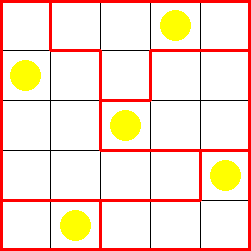

[4, 6, 13, 20, 22]

In [47]:
solver("Exemples/test3.txt", 1, convert_to_3sat=False, local=False)